In [1]:
import numpy as np
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import warnings
from itertools import product
from polarization_controller import optical_fiber, polarization_splitter_rotator, mzi, phase_aligner, polarization_bidi, polarization_bidi_double_fiber, polarization_bidi_single_fiber
from scipy.optimize import minimize
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")

## MZI working

40401it [00:04, 8948.74it/s]
4it [00:00, 100.28it/s]


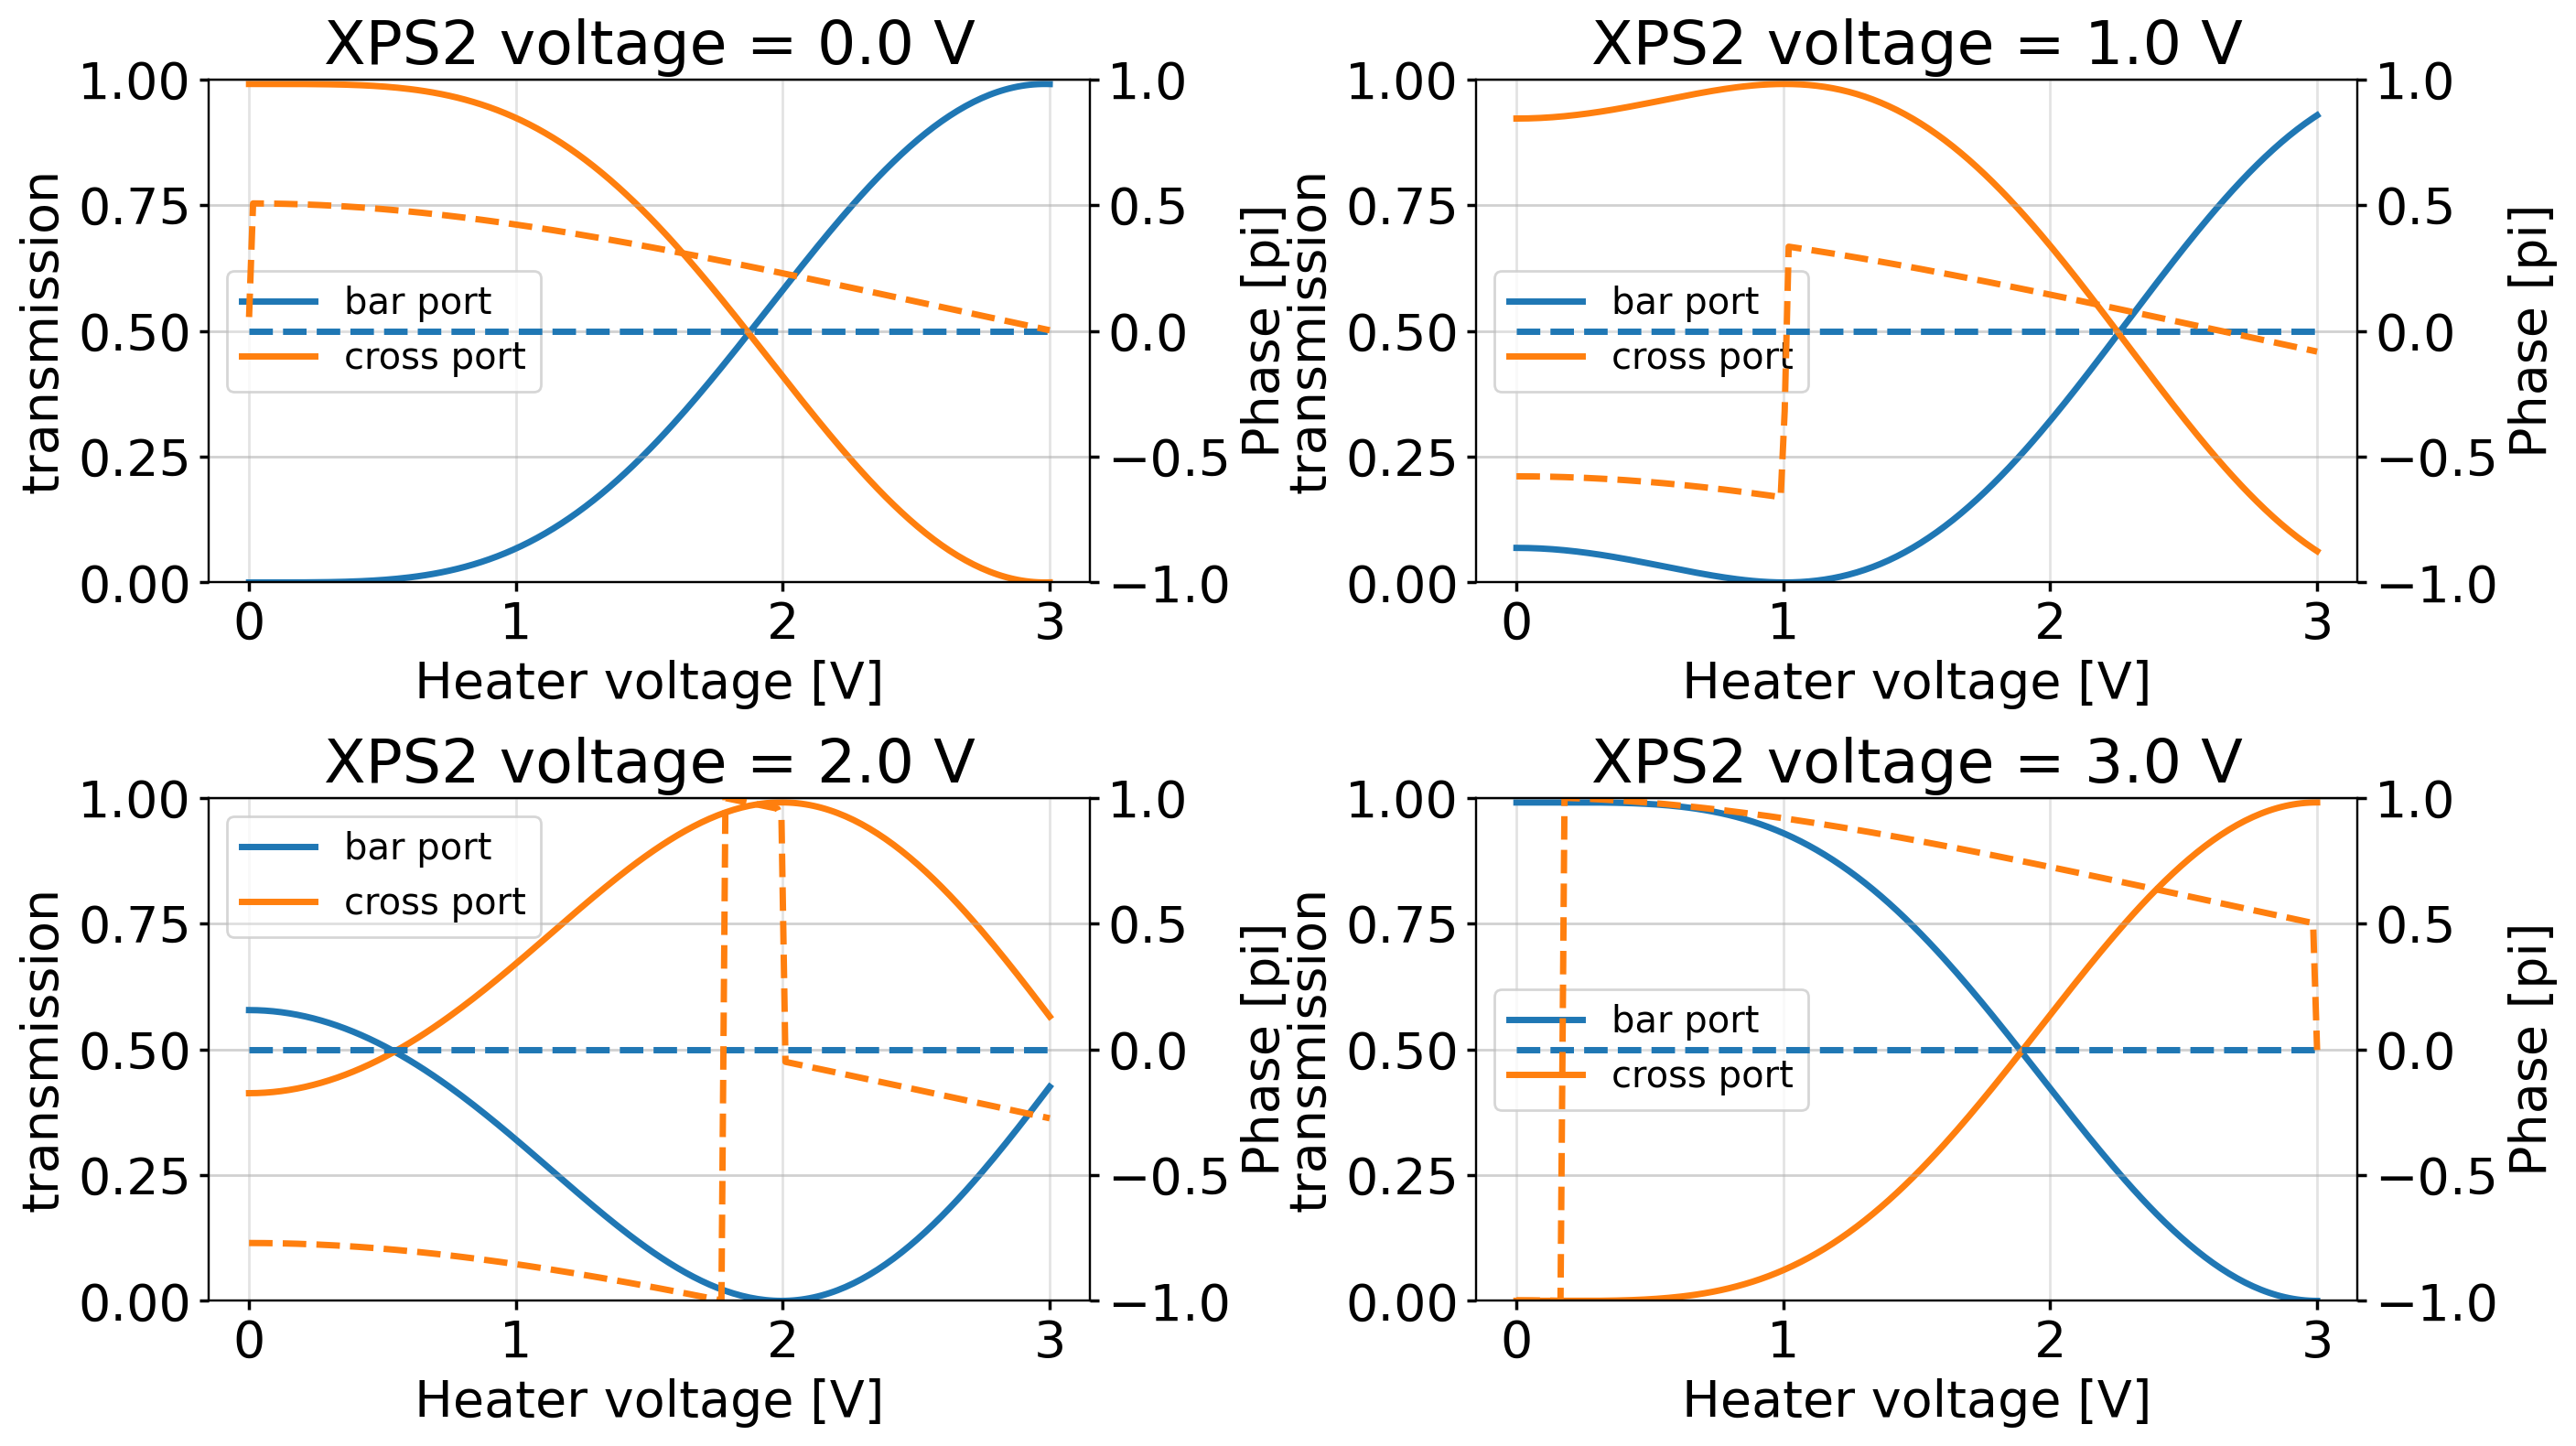

In [2]:
_mzi = mzi()

sample_points = 201
voltages = np.linspace(0, 3, sample_points)
phase_shifts = np.linspace(-np.pi, np.pi, sample_points)

mzi_bar_port_tx = []
mzi_cross_port_tx = []
mzi_bar_port_angle = []
mzi_cross_port_angle = []

for xps1_volt, xps2_volt in tqdm(product(voltages, voltages)):
    _mzi.XPS1.heater_voltage = xps1_volt
    _mzi.XPS2.heater_voltage = xps2_volt

    input_state = np.array([1, 0, 0, 0])
    output_state = _mzi.smatrix @ input_state

    mzi_bar_port_tx.append(np.abs(output_state)[2]**2)
    mzi_cross_port_tx.append(np.abs(output_state)[3]**2)

    optical_phase = np.angle(output_state)
    mzi_bar_port_angle.append(np.angle(output_state)[1])
    mzi_cross_port_angle.append(np.angle(output_state)[2])

mzi_bar_port_tx = np.array(mzi_bar_port_tx).reshape(sample_points, sample_points)
mzi_cross_port_tx = np.array(mzi_cross_port_tx).reshape(sample_points, sample_points)
mzi_bar_port_angle = np.array(mzi_bar_port_angle).reshape(sample_points, sample_points)
mzi_cross_port_angle = np.array(mzi_cross_port_angle).reshape(sample_points, sample_points)

voltage_plot = np.array([0,1.0, 2.0, 3.0])

plt.figure(figsize=(7.*2, 4*2))
for idd_volt, volt_plot in tqdm(enumerate(voltage_plot)):
    ax1 = plt.subplot(2, 2, idd_volt+1)
    argmin = np.argmin(np.abs(voltages - volt_plot))
    ax1.plot(voltages, mzi_bar_port_tx[:,argmin], label="bar port")
    ax1.plot(voltages, mzi_cross_port_tx[:,argmin], label="cross port")
    ax1.set_title("XPS2 voltage = {:.1f} V".format(voltages[argmin]))
    ax1.set_ylim([0, 1])
    ax1.legend()
    ax1.set_xlabel("Heater voltage [V]")
    ax1.set_ylabel("transmission")
    ax2 = ax1.twinx()
    ax2.plot(voltages, mzi_bar_port_angle[:,argmin]/np.pi, linestyle='--',label="bar port")
    ax2.plot(voltages, mzi_cross_port_angle[:,argmin]/np.pi, linestyle='--',label="cross port")
    ax2.set_ylim([-1, 1])
    ax2.set_ylabel("Phase [pi]")
plt.tight_layout()

## Phase aligner

40401it [00:03, 11028.91it/s]
4it [00:00, 92.57it/s]


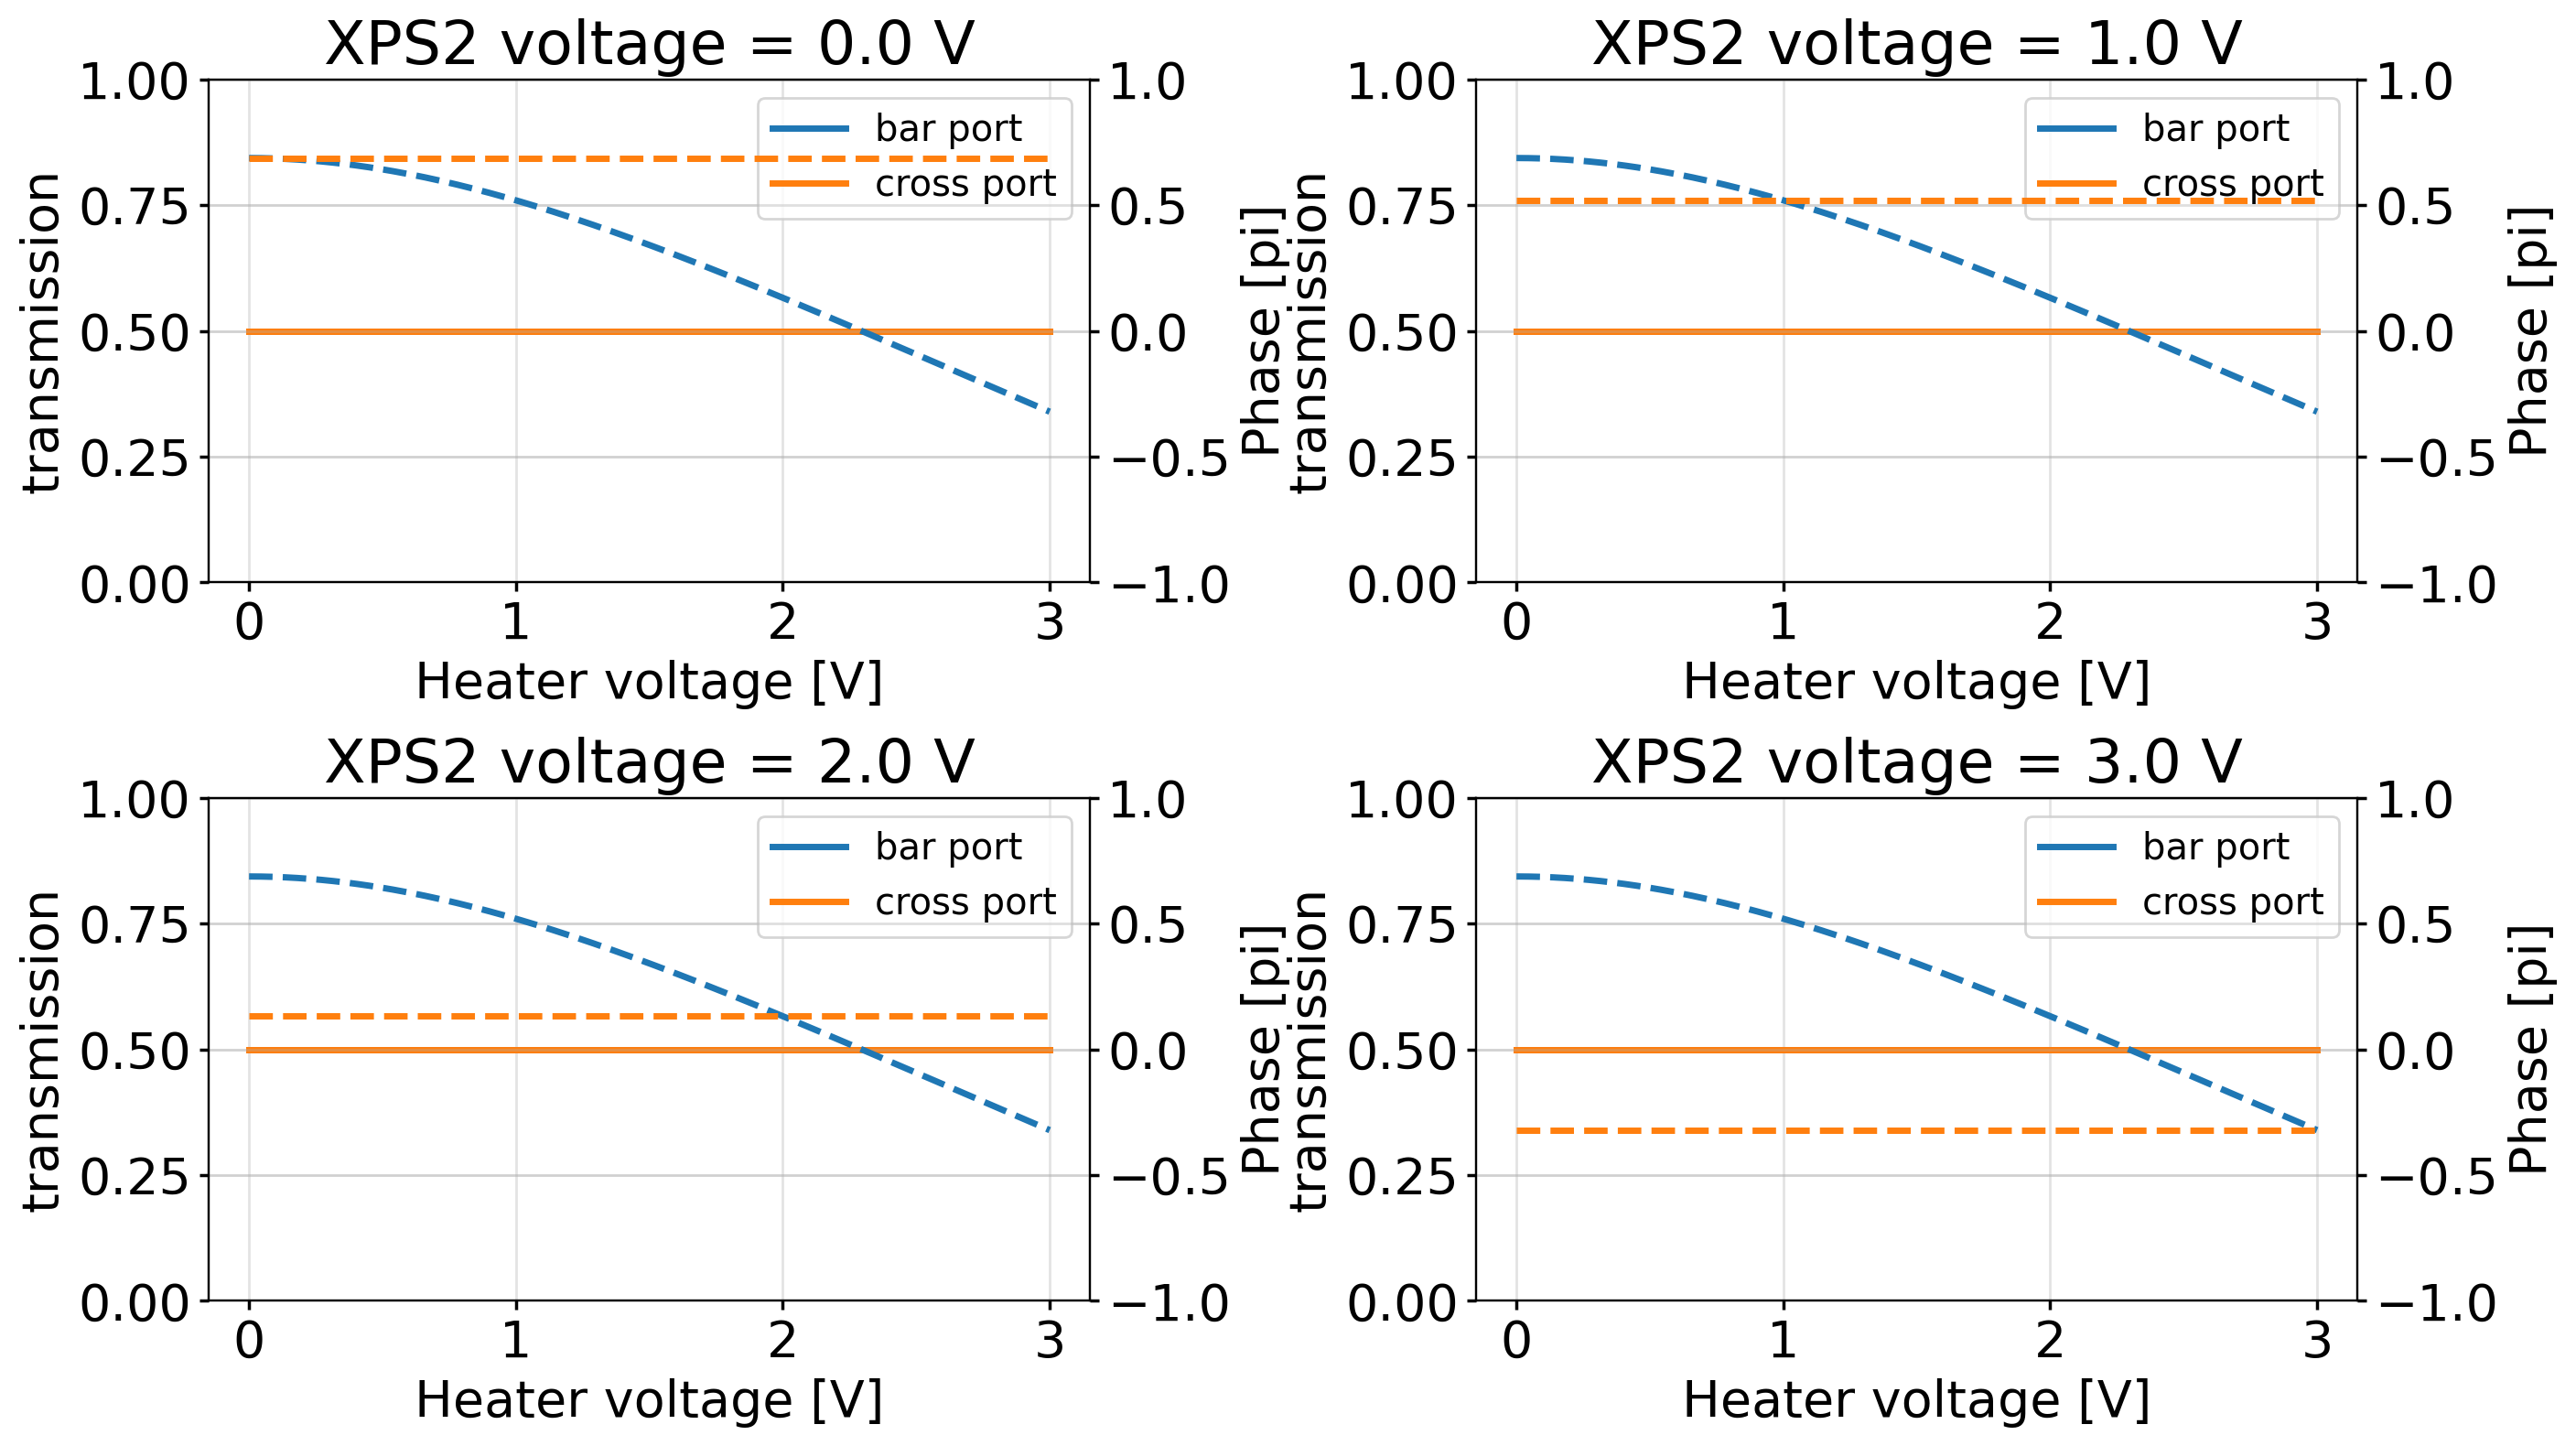

In [3]:
_pa = phase_aligner()

pa_bar_port_tx = []
pa_cross_port_tx = []
pa_bar_port_angle = []
pa_cross_port_angle = []

for xps1_volt, xps2_volt in tqdm(product(voltages, voltages)):
    _pa.XPS1.heater_voltage = xps1_volt
    _pa.XPS2.heater_voltage = xps2_volt
    
    input_state = np.array([np.sqrt(0.5), 0, 0, np.sqrt(0.5)])
    output_state = _pa.smatrix @ input_state

    pa_bar_port_tx.append(np.abs(output_state)[1]**2)
    pa_cross_port_tx.append(np.abs(output_state)[2]**2)

    optical_phase = np.angle(output_state)
    pa_bar_port_angle.append(np.angle(output_state)[1])
    pa_cross_port_angle.append(np.angle(output_state)[2])

pa_bar_port_tx = np.array(pa_bar_port_tx).reshape(sample_points, sample_points)
pa_cross_port_tx = np.array(pa_cross_port_tx).reshape(sample_points, sample_points)
pa_bar_port_angle = np.array(pa_bar_port_angle).reshape(sample_points, sample_points)
pa_cross_port_angle = np.array(pa_cross_port_angle).reshape(sample_points, sample_points)

voltage_plot = np.array([0,1.0, 2.0, 3.0])

plt.figure(figsize=(7.*2, 4*2))
for idd_volt, volt_plot in tqdm(enumerate(voltage_plot)):
    ax1 = plt.subplot(2, 2, idd_volt+1)
    argmin = np.argmin(np.abs(voltages - volt_plot))
    ax1.plot(voltages, pa_bar_port_tx[:,argmin], label="bar port")
    ax1.plot(voltages, pa_cross_port_tx[:,argmin], label="cross port")
    ax1.set_title("XPS2 voltage = {:.1f} V".format(voltages[argmin]))
    ax1.set_ylim([0, 1])
    ax1.legend()
    ax1.set_xlabel("Heater voltage [V]")
    ax1.set_ylabel("transmission")
    ax2 = ax1.twinx()
    ax2.plot(voltages, pa_bar_port_angle[:,argmin]/np.pi, linestyle='--',label="bar port")
    ax2.plot(voltages, pa_cross_port_angle[:,argmin]/np.pi, linestyle='--',label="cross port")
    ax2.set_ylim([-1, 1])
    ax2.set_ylabel("Phase [pi]")
plt.tight_layout()

## Polarization splitter rotator

100%|██████████| 201/201 [00:00<00:00, 55206.28it/s]


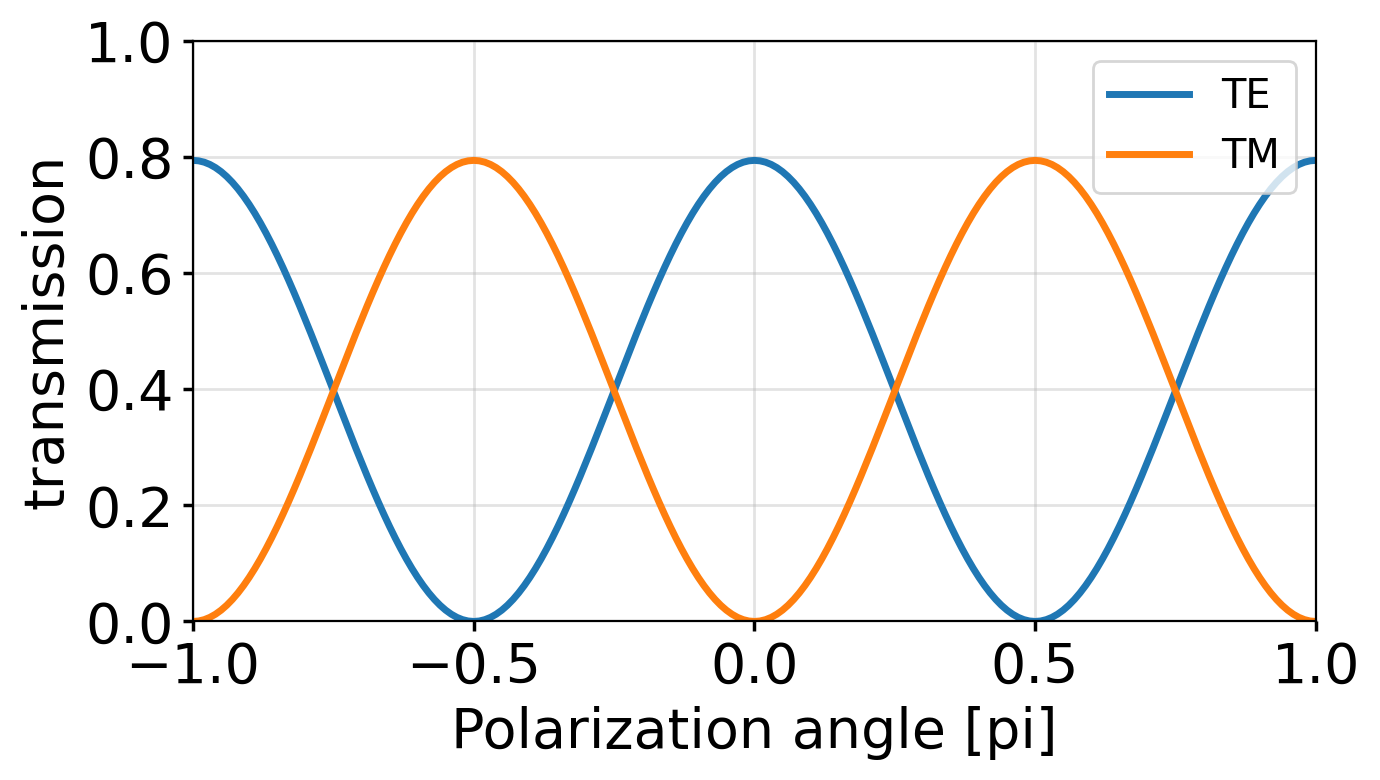

In [4]:
_psr = polarization_splitter_rotator()

psr_te_tx = []
psr_tm_tx = []
psr_te_angle = []
psr_tm_angle = []

for phase in tqdm(phase_shifts):
    input_state = np.array([np.cos(phase), 0, 0,  np.sin(phase)])
    output_state = _psr.smatrix @ input_state

    psr_te_tx.append(np.abs(output_state)[1]**2)
    psr_tm_tx.append(np.abs(output_state)[2]**2)

    optical_phase = np.angle(output_state)

psr_te_tx = np.array(psr_te_tx)
psr_tm_tx = np.array(psr_tm_tx)

plt.figure(figsize=(7,4))
ax1 = plt.subplot(111)
ax1.plot(phase_shifts/np.pi, psr_te_tx, label="TE")
ax1.plot(phase_shifts/np.pi, psr_tm_tx, label="TM")
ax1.set_xlim([-1, 1])
ax1.set_xlabel("Polarization angle [pi]")
ax1.set_ylabel("transmission")
ax1.set_ylim([0, 1])
ax1.legend()
plt.tight_layout()


## Optical fiber

201it [00:00, 50719.23it/s]


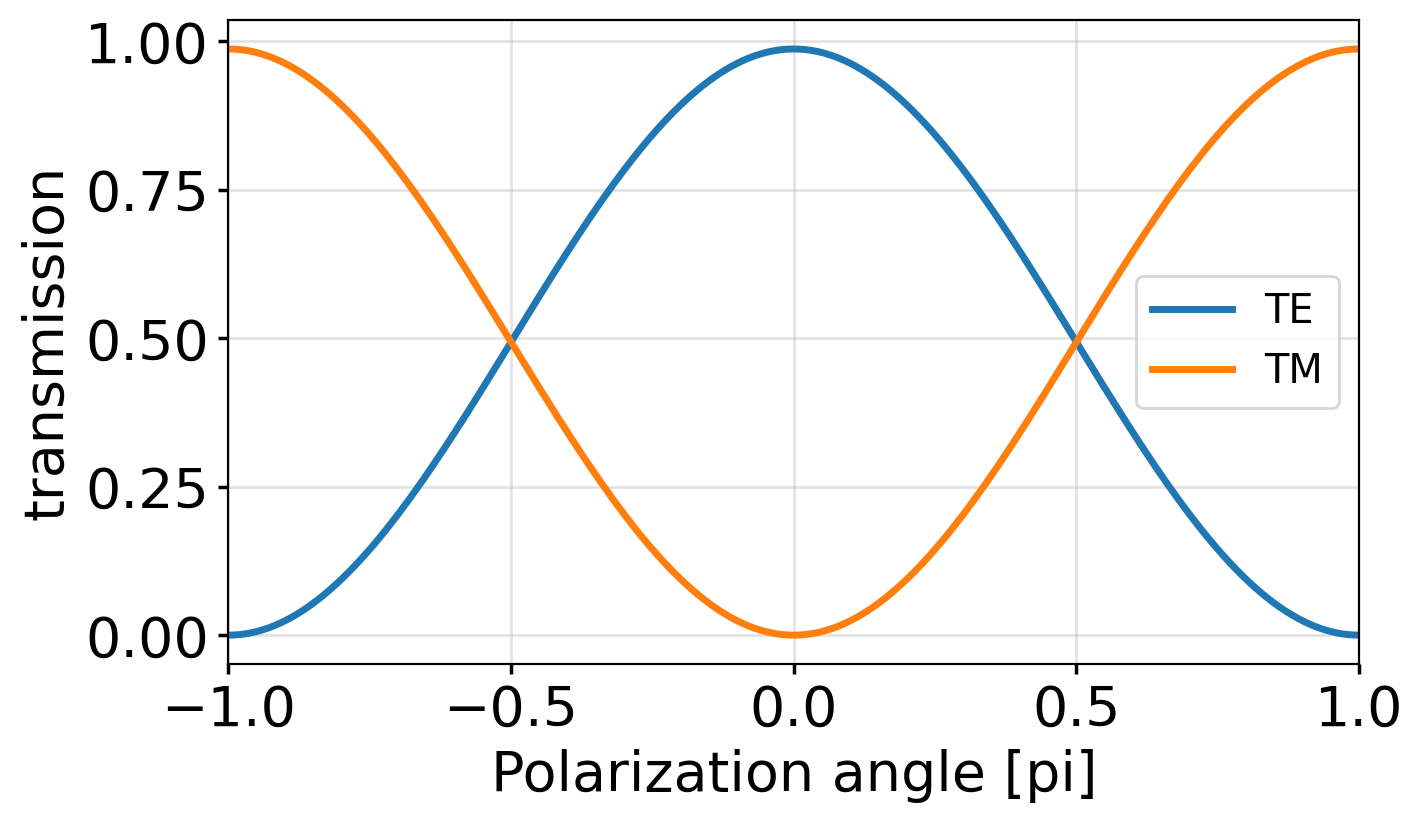

In [5]:
_fiber = optical_fiber()

fiber_te_tx = []
fiber_tm_tx = []
fiber_te_angle = []
fiber_tm_angle = []

rotation_1 = np.random.permutation(sample_points)
rotation_2 = np.random.permutation(sample_points)
rotation_3 = np.random.permutation(sample_points)
rotation_4 = np.random.permutation(sample_points)

for idd, phase in tqdm(enumerate(phase_shifts)):
    _fiber._rotation = (0.0, phase, 0.0, 0.0)
    
    _fiber.recursive_update()

    input_state = np.array([1, 0, 0,  0])
    output_state = _fiber.smatrix @ input_state

    fiber_te_tx.append(np.abs(output_state)[1]**2)
    fiber_tm_tx.append(np.abs(output_state)[2]**2)

fiber_te_tx = np.array(fiber_te_tx)
fiber_tm_tx = np.array(fiber_tm_tx)

fiber_te_angle = np.array(fiber_te_angle)

plt.figure(figsize=(7,4))
ax1 = plt.subplot(111)
ax1.plot(phase_shifts/np.pi, fiber_te_tx, label="TE")
ax1.plot(phase_shifts/np.pi, fiber_tm_tx, label="TM")
ax1.set_xlim([-1, 1])
ax1.set_xlabel("Polarization angle [pi]")
ax1.set_ylabel("transmission")
ax1.legend()


## Polarization controller check

In [6]:
p_bidi_sf = polarization_bidi_single_fiber(psr_bool=False, tx_num_mzi_stages=1)

In [7]:
sample_points = 201

voltages = np.linspace(0, 3, sample_points)
phase_shifts = np.linspace(-np.pi, np.pi, sample_points)

rotation_rx = phase_shifts[np.random.permutation(sample_points)]
rotation_ry = phase_shifts[np.random.permutation(sample_points)]
rotation_rz = phase_shifts[np.random.permutation(sample_points)]
rotation_delta = phase_shifts[np.random.permutation(sample_points)]

p_bidi_sf.fiber_1._rotation = (rotation_rx[0], rotation_ry[0], rotation_rz[0], rotation_delta[0])

p_bidi_sf.recursive_update()

In [8]:
def objective_function_sf(voltages, input_state, params):
  """
  Objective function for the optimization.
  Args:
      bidi: Bidi class representing the optical link.
      voltages: Voltages applied to the phase shifters.
      input_state: Input state of the device.
      params: Dictionary of parameters for the optimization.
  Returns:
      The cost function.
  """
  p_bidi_sf.bidi_tx.pa.XPS1.heater_voltage = voltages[0]
  p_bidi_sf.bidi_tx.pa.XPS2.heater_voltage = voltages[1]
  p_bidi_sf.bidi_tx.mzi_1.XPS1.heater_voltage = voltages[2]
  p_bidi_sf.bidi_tx.mzi_1.XPS2.heater_voltage = voltages[3]

  if len(voltages) > 4:
    p_bidi_sf.bidi_tx.mzi_2.XPS1.heater_voltage = voltages[4]
    p_bidi_sf.bidi_tx.mzi_2.XPS2.heater_voltage = voltages[5]

  p_bidi_sf.recursive_update()

  output_state = p_bidi_sf.smatrix @ input_state
  
  I_back_top_port = np.abs(output_state[0])**2
  I_back_bottom_port = np.abs(output_state[1])**2
  I_top_port = np.abs(output_state[2])**2
  I_bottom_port = np.abs(output_state[3])**2

  intensities = [I_back_top_port, I_back_bottom_port, I_top_port, I_bottom_port]

  curr_params = []
  for volts in voltages:
    curr_params.append(volts)
  for state in output_state:
    curr_params.append(np.abs(state)**2)
  for inten in intensities:
    curr_params.append(inten)
  params.append(curr_params)

  return -1 * I_top_port

def plot_optimization(params):
  iters = np.arange(len(params))
  params = np.array(params)
  labels = ['PT-1:XPS1', 'PT-1:XPS2', 'MZI-1:XPS1', 'MZI-1: XPS2', 'MZI-2:XPS1', 'MZI-2: XPS2']
  plt.figure(figsize=(7.5, 8), dpi=400)
  plt.subplot(2, 1, 1)
  if len(params[0,:]) > 12:
    plt.plot(iters, params[:, 0:6], label=labels)
  else:
    plt.plot(iters, params[:, 0:4], label=labels[0:4])

  plt.ylabel('Voltage [V]')
  plt.xlabel('Iteration number')
  plt.title('Polarization controller settings')
  plt.legend(fontsize=12)
  plt.grid(True, which="both", ls="dashed", color='.9')

  labels = [
      "Monitor PD",
      "RX-A",
      "TE-pol to RX-B",
      "TM-pol to RX-B", 
  ]
  plt.subplot(2, 1, 2)
  if len(params[0,:]) > 12:
    plt.plot(iters, params[:, 12:], label=labels)
  else:
    plt.plot(iters, params[:, 8:], label=labels)

  plt.ylabel('Transmission (a.u.)')
  plt.xlabel('Iteration number')
  plt.title('Chip 1 to Chip 2')
  plt.legend(fontsize=10)
  plt.grid(True, which="both", ls="dashed", color='.9')
  plt.tight_layout()

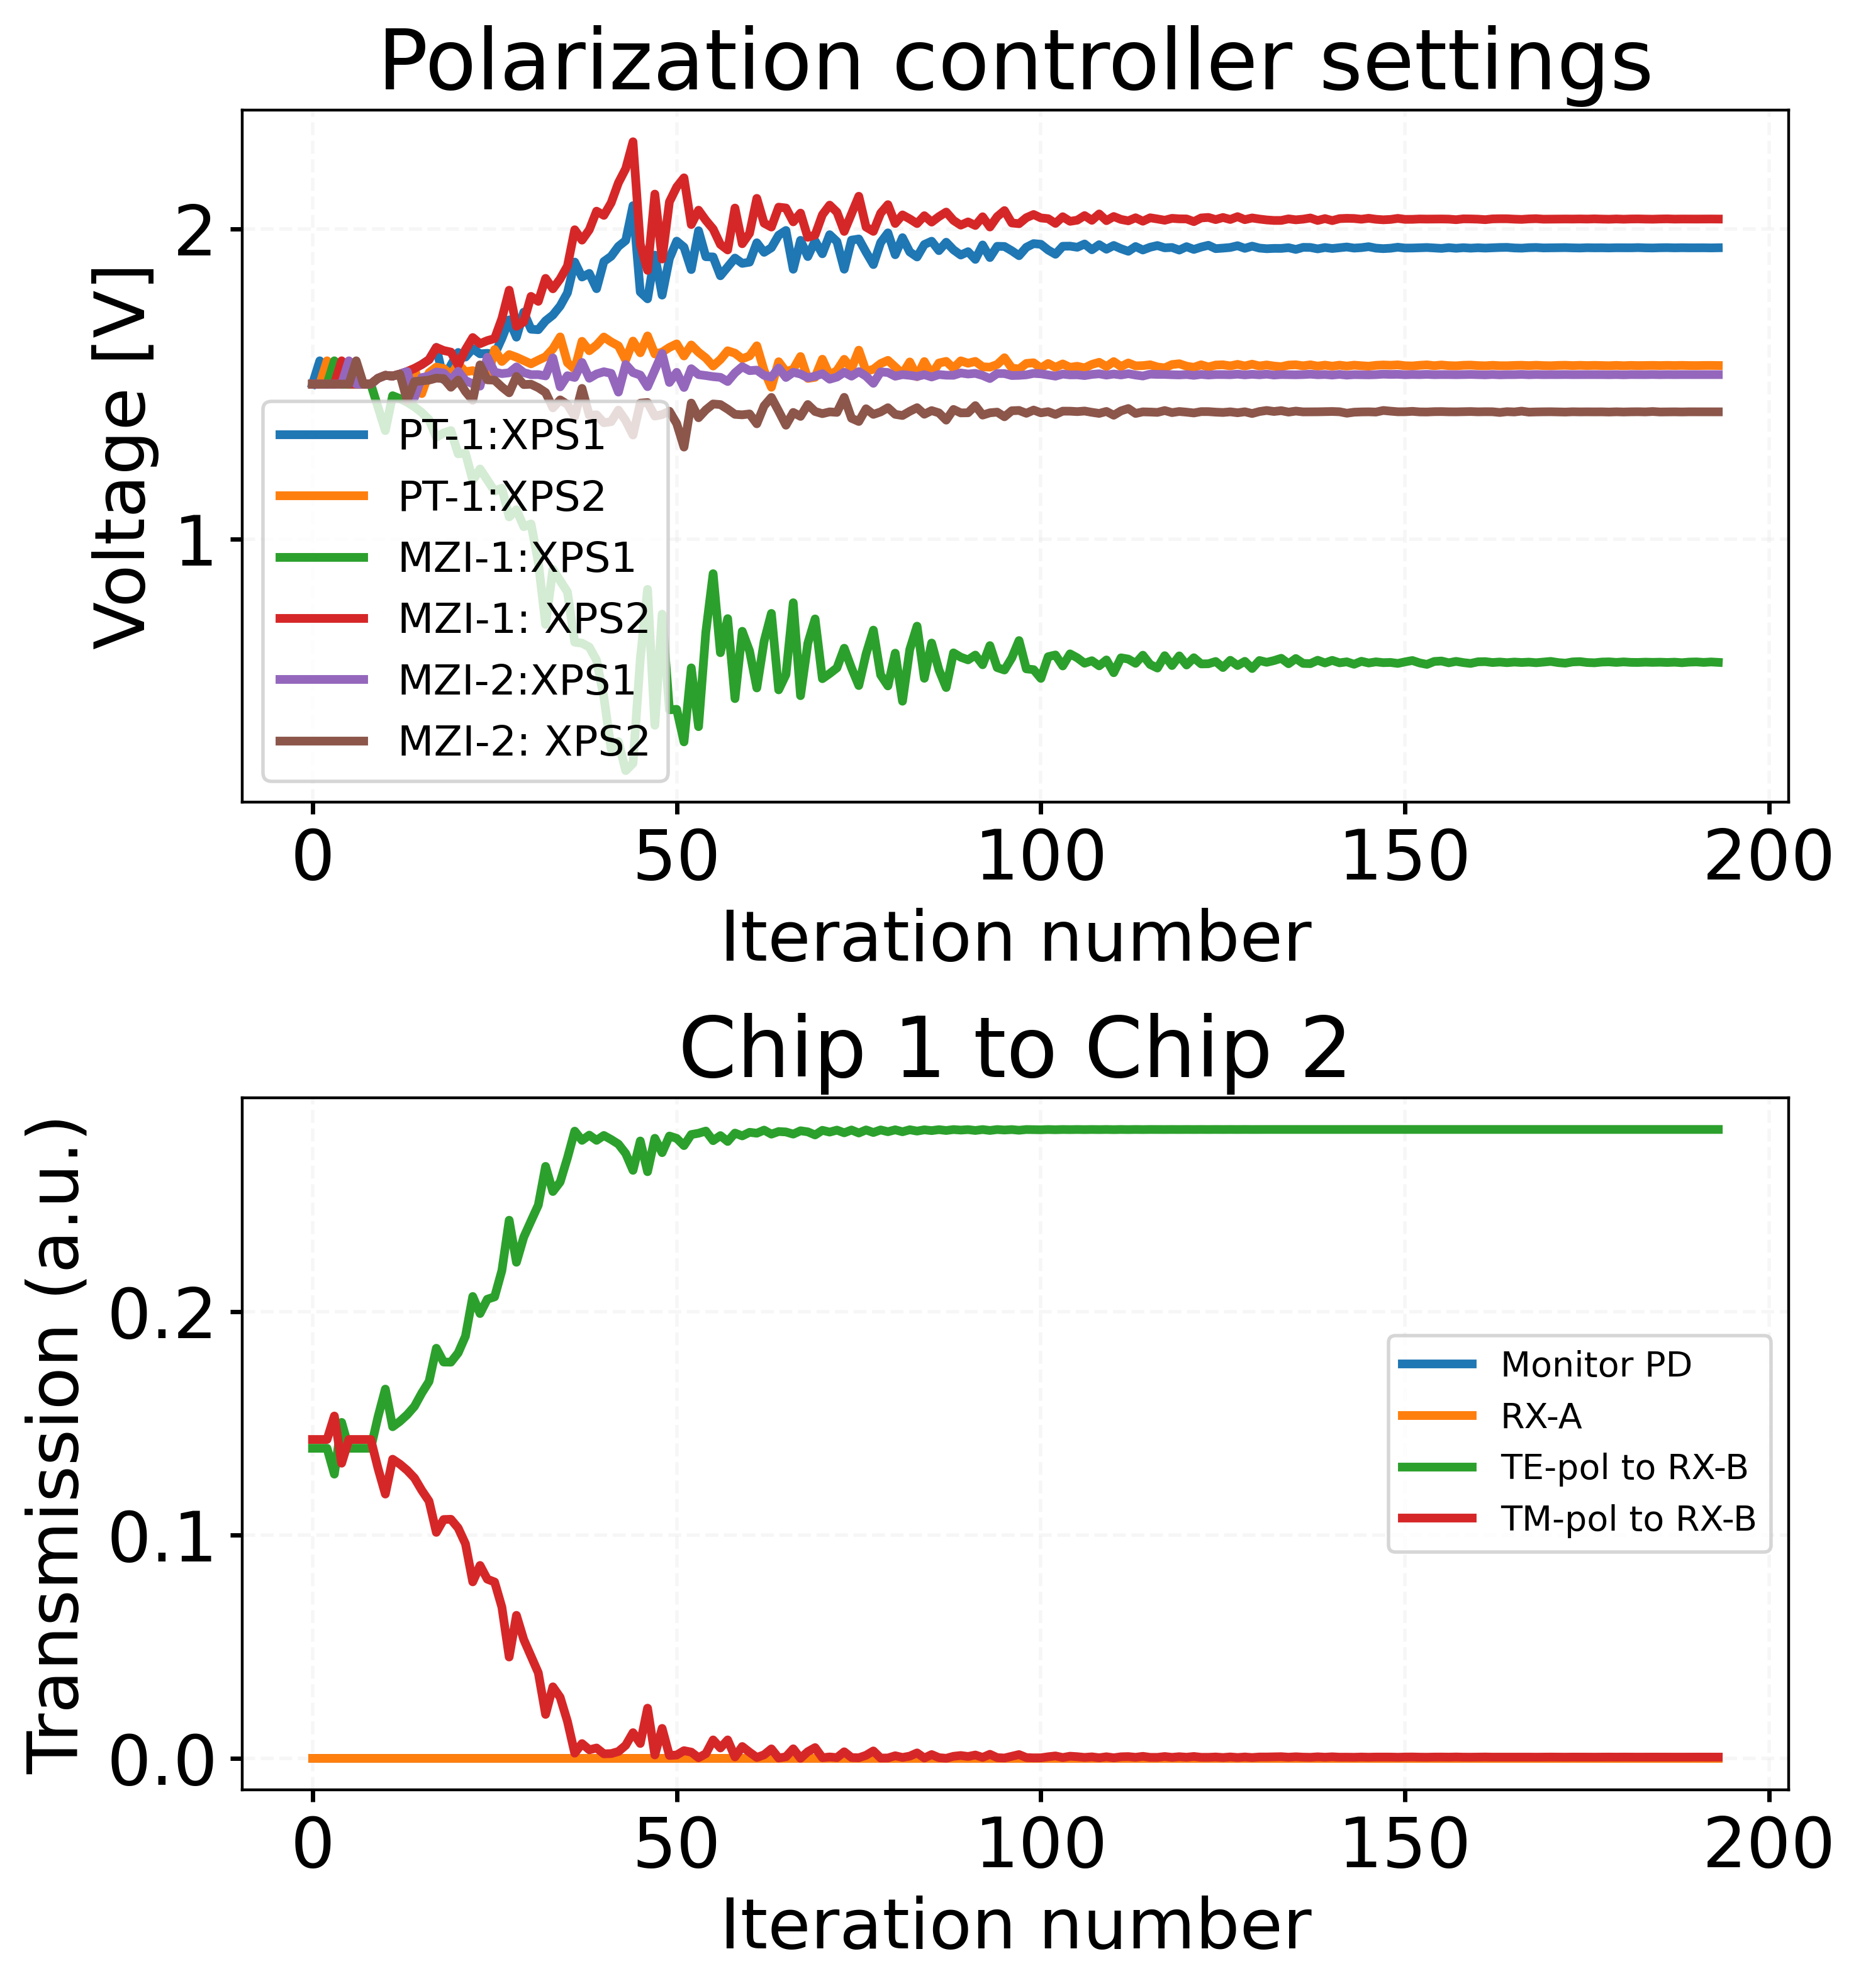

In [9]:
bounds = [(0, 3), (0, 3), (0, 3), (0, 3), (0,3), (0,3), (0,3), (0,3)]
input_state = np.array([0, 1, 0, 0])

opts = {
  "maxiter": 1000,
  'xatol': 1e-3,
  'fatol': 1e-3,
}

params = []

result = minimize(
  objective_function_sf,
  ((1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5)),
  bounds=bounds,
  args=(input_state, params),
  method='Nelder-Mead',
  options=opts
  )

plot_optimization(params)

In [10]:
input_state_reverse = np.array([0, 0, 1, 0])
output_state_reverse = p_bidi_sf.smatrix @ input_state_reverse
print(np.abs(output_state_reverse)**2)

[9.94776913e-09 2.81437269e-01 1.65113158e-10 2.58920638e-11]


In [11]:
p_bidi_df = polarization_bidi_double_fiber(psr_bool=False, tx_num_mzi_stages=1)

In [12]:
p_bidi_df.fiber_1._rotation = (rotation_rx[0], rotation_ry[0], rotation_rz[0], rotation_delta[0])
p_bidi_df.fiber_2._rotation = (rotation_rx[1], rotation_ry[1], rotation_rz[1], rotation_delta[1])

p_bidi_df.recursive_update()

In [13]:
def objective_function_df(voltages, input_state, params):
  """
  Objective function for the optimization.
  Args:
      bidi: Bidi class representing the optical link.
      voltages: Voltages applied to the phase shifters.
      input_state: Input state of the device.
      params: Dictionary of parameters for the optimization.
  Returns:
      The cost function.
  """
  p_bidi_df.bidi_tx.pa.XPS1.heater_voltage = voltages[0]
  p_bidi_df.bidi_tx.pa.XPS2.heater_voltage = voltages[1]
  p_bidi_df.bidi_tx.mzi_1.XPS1.heater_voltage = voltages[2]
  p_bidi_df.bidi_tx.mzi_1.XPS2.heater_voltage = voltages[3]

  if len(voltages) > 4:
    p_bidi_df.bidi_tx.mzi_2.XPS1.heater_voltage = voltages[4]
    p_bidi_df.bidi_tx.mzi_2.XPS2.heater_voltage = voltages[5]

  p_bidi_df.recursive_update()

  output_state = p_bidi_df.smatrix @ input_state
  
  I_back_top_port = np.abs(output_state[0])**2
  I_back_bottom_port = np.abs(output_state[1])**2
  I_top_port = np.abs(output_state[2])**2
  I_bottom_port = np.abs(output_state[3])**2

  intensities = [I_back_top_port, I_back_bottom_port, I_top_port, I_bottom_port]

  curr_params = []
  for volts in voltages:
    curr_params.append(volts)
  for state in output_state:
    curr_params.append(np.abs(state)**2)
  for inten in intensities:
    curr_params.append(inten)
  params.append(curr_params)

  return -1 * I_top_port

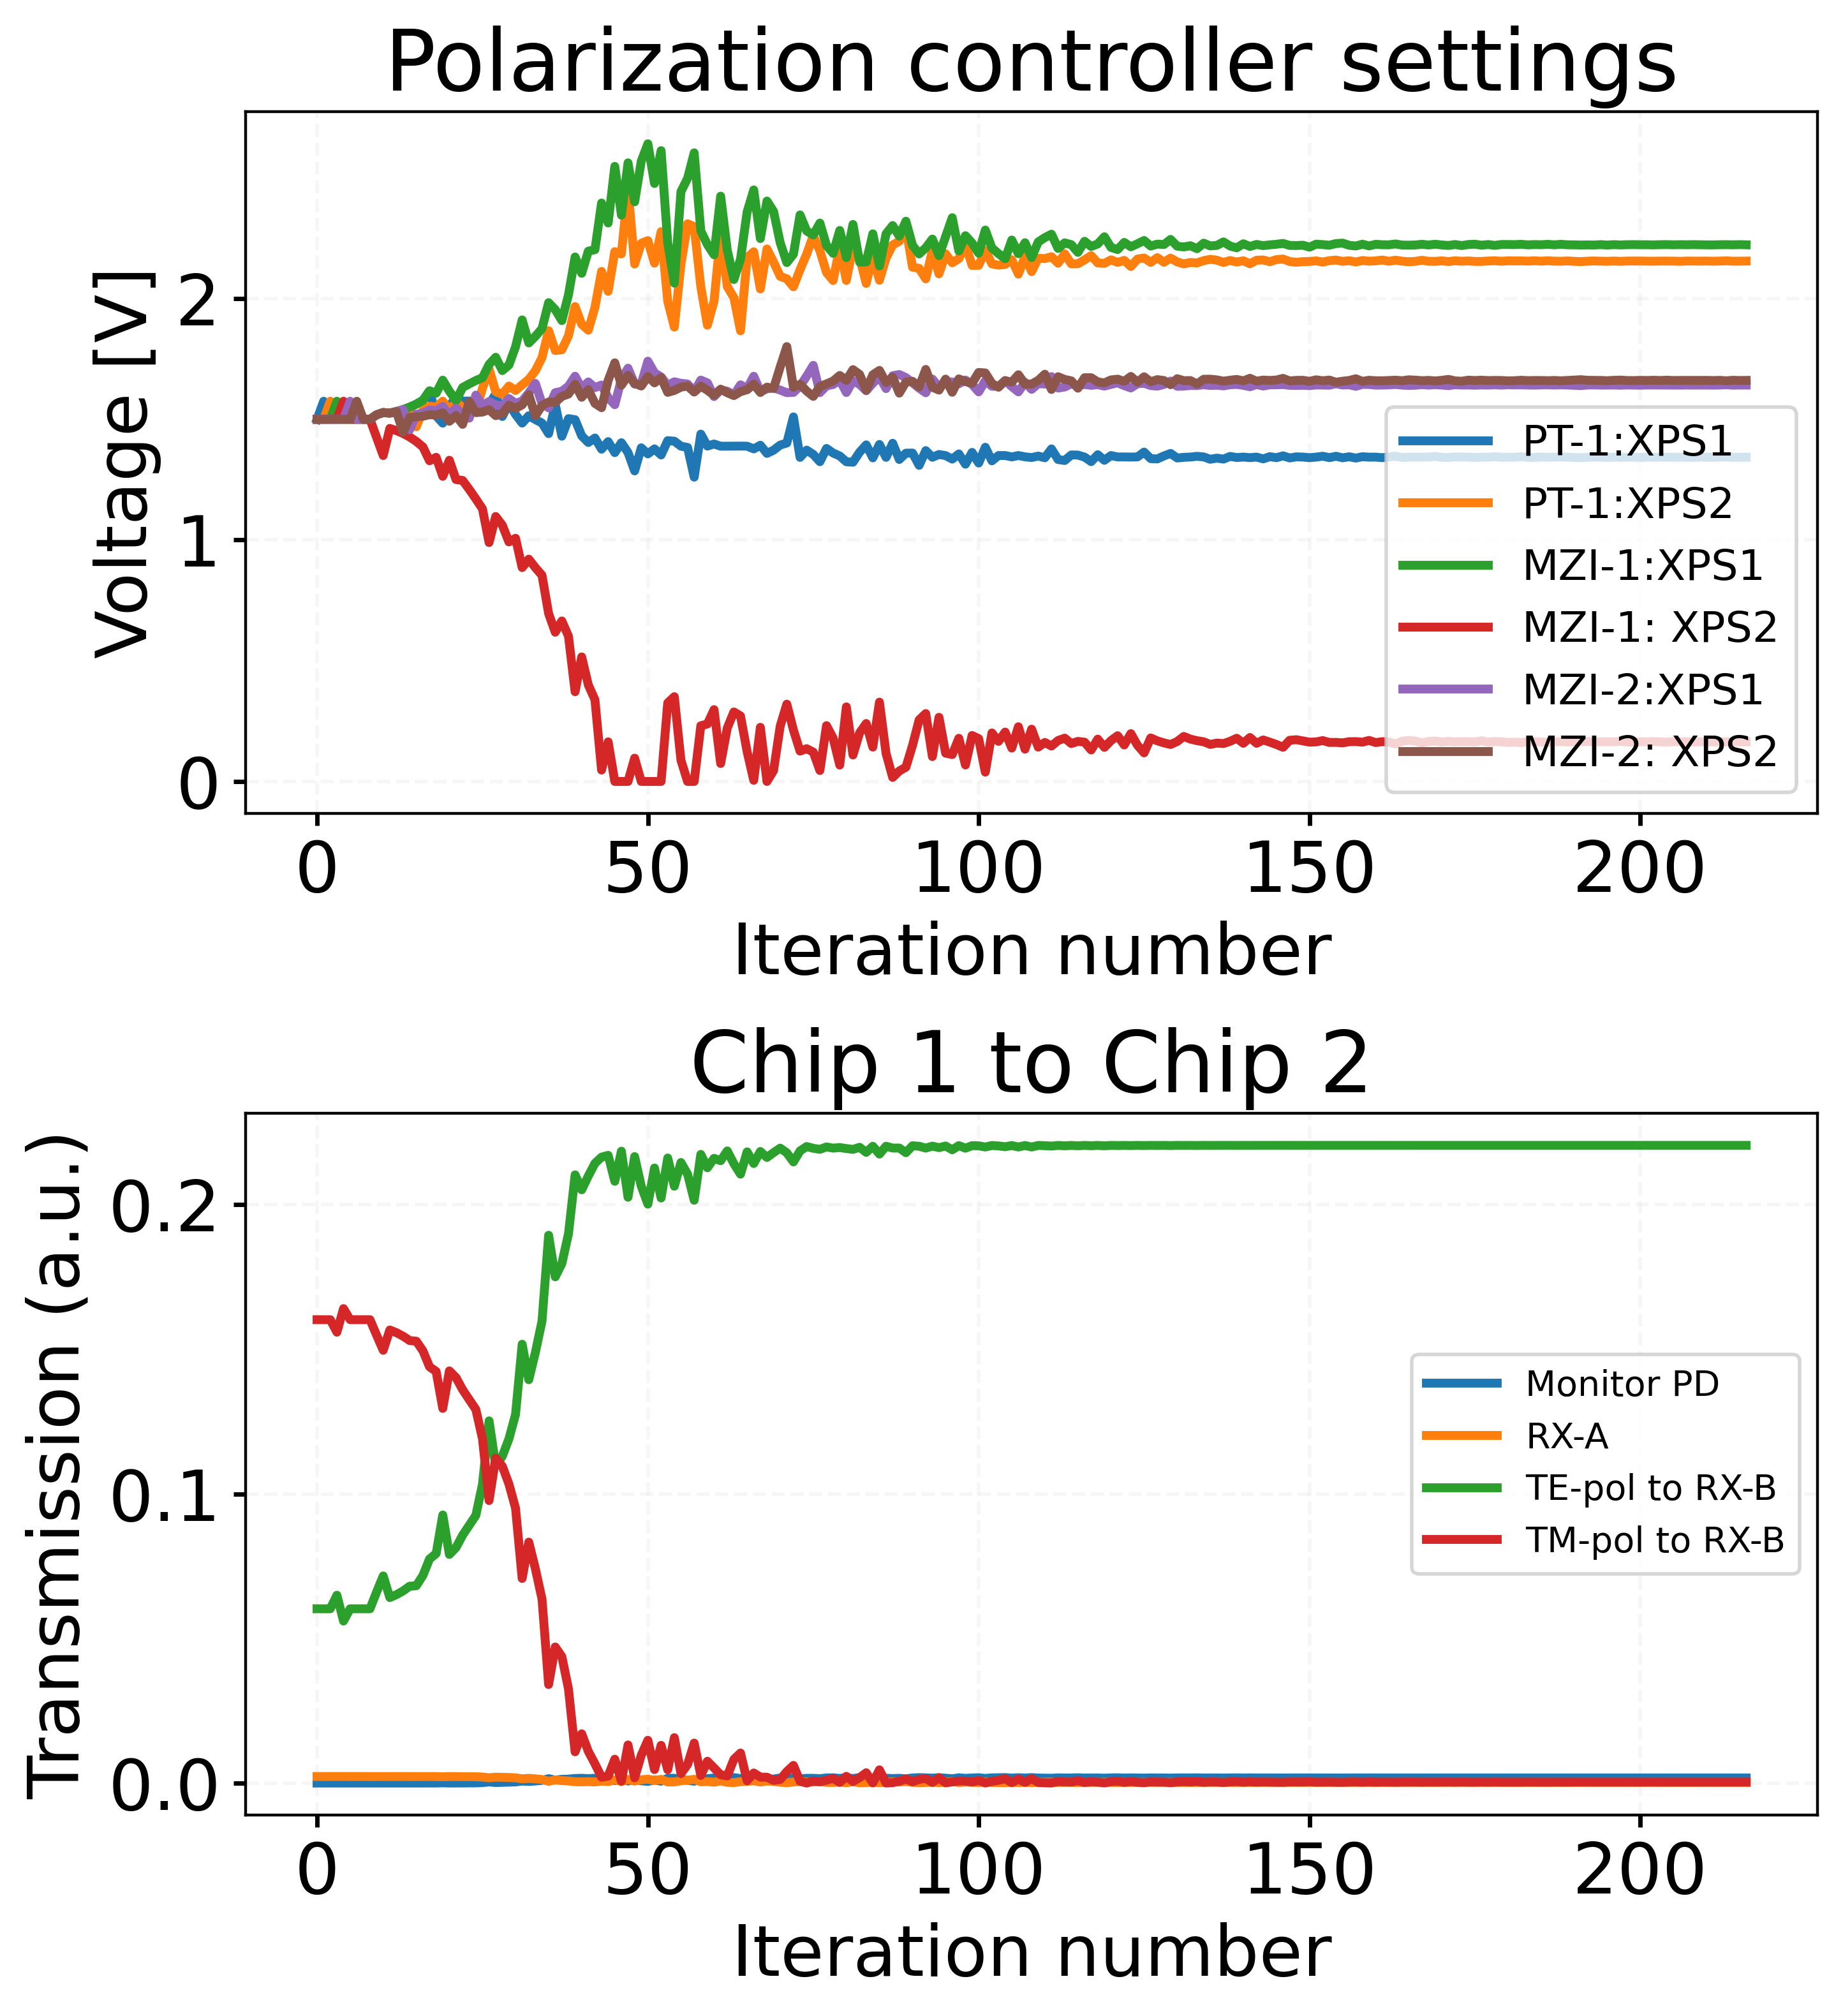

In [14]:
bounds = [(0, 3), (0, 3), (0, 3), (0, 3), (0,3), (0,3), (0,3), (0,3)]
input_state = np.array([0, 1, 0, 0])

opts = {
  "maxiter": 1000,
  'xatol': 1e-3,
  'fatol': 1e-3,
}

params = []

result = minimize(
  objective_function_df,
  ((1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5)),
  bounds=bounds,
  args=(input_state, params),
  method='Nelder-Mead',
  options=opts
  )

plot_optimization(params)

In [15]:
input_state_reverse = np.array([0, 0, 1, 0])
output_state_reverse = p_bidi_df.smatrix @ input_state_reverse
print(np.abs(output_state_reverse)**2)

[3.59938022e-09 2.20486519e-01 6.67220679e-04 2.76730618e-03]


In [16]:
p_bidi = polarization_bidi(psr_bool=False, tx_num_mzi_stages=1)

p_bidi.fiber_1._rotation = (rotation_rx[0], rotation_ry[0], rotation_rz[0], rotation_delta[0])
p_bidi.fiber_2._rotation = (rotation_rx[1], rotation_ry[1], rotation_rz[1], rotation_delta[1])
p_bidi.fiber_3._rotation = (rotation_rx[2], rotation_ry[2], rotation_rz[2], rotation_delta[2])
p_bidi.fiber_4._rotation = (rotation_rx[3], rotation_ry[3], rotation_rz[3], rotation_delta[3])
p_bidi.fiber_5._rotation = (rotation_rx[4], rotation_ry[4], rotation_rz[4], rotation_delta[4])
p_bidi.fiber_6._rotation = (rotation_rx[5], rotation_ry[5], rotation_rz[5], rotation_delta[5])
p_bidi.fiber_7._rotation = (rotation_rx[6], rotation_ry[6], rotation_rz[6], rotation_delta[6])

p_bidi.recursive_update()

In [17]:
def objective_function(voltages, input_state, params):
  """
  Objective function for the optimization.
  Args:
      bidi: Bidi class representing the optical link.
      voltages: Voltages applied to the phase shifters.
      input_state: Input state of the device.
      params: Dictionary of parameters for the optimization.
  Returns:
      The cost function.
  """
  p_bidi.bidi_tx.pa.XPS1.heater_voltage = voltages[0]
  p_bidi.bidi_tx.pa.XPS2.heater_voltage = voltages[1]
  p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = voltages[2]
  p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = voltages[3]

  if len(voltages) > 4:
    p_bidi.bidi_tx.mzi_2.XPS1.heater_voltage = voltages[4]
    p_bidi.bidi_tx.mzi_2.XPS2.heater_voltage = voltages[5]

  p_bidi.recursive_update()

  output_state = p_bidi.smatrix @ input_state
  
  I_back_top_port = np.abs(output_state[0])**2
  I_back_bottom_port = np.abs(output_state[1])**2
  I_top_port = np.abs(output_state[2])**2
  I_bottom_port = np.abs(output_state[3])**2

  intensities = [I_back_top_port, I_back_bottom_port, I_top_port, I_bottom_port]

  curr_params = []
  for volts in voltages:
    curr_params.append(volts)
  for state in output_state:
    curr_params.append(np.abs(state)**2)
  for inten in intensities:
    curr_params.append(inten)
  params.append(curr_params)

  return -1 * I_top_port

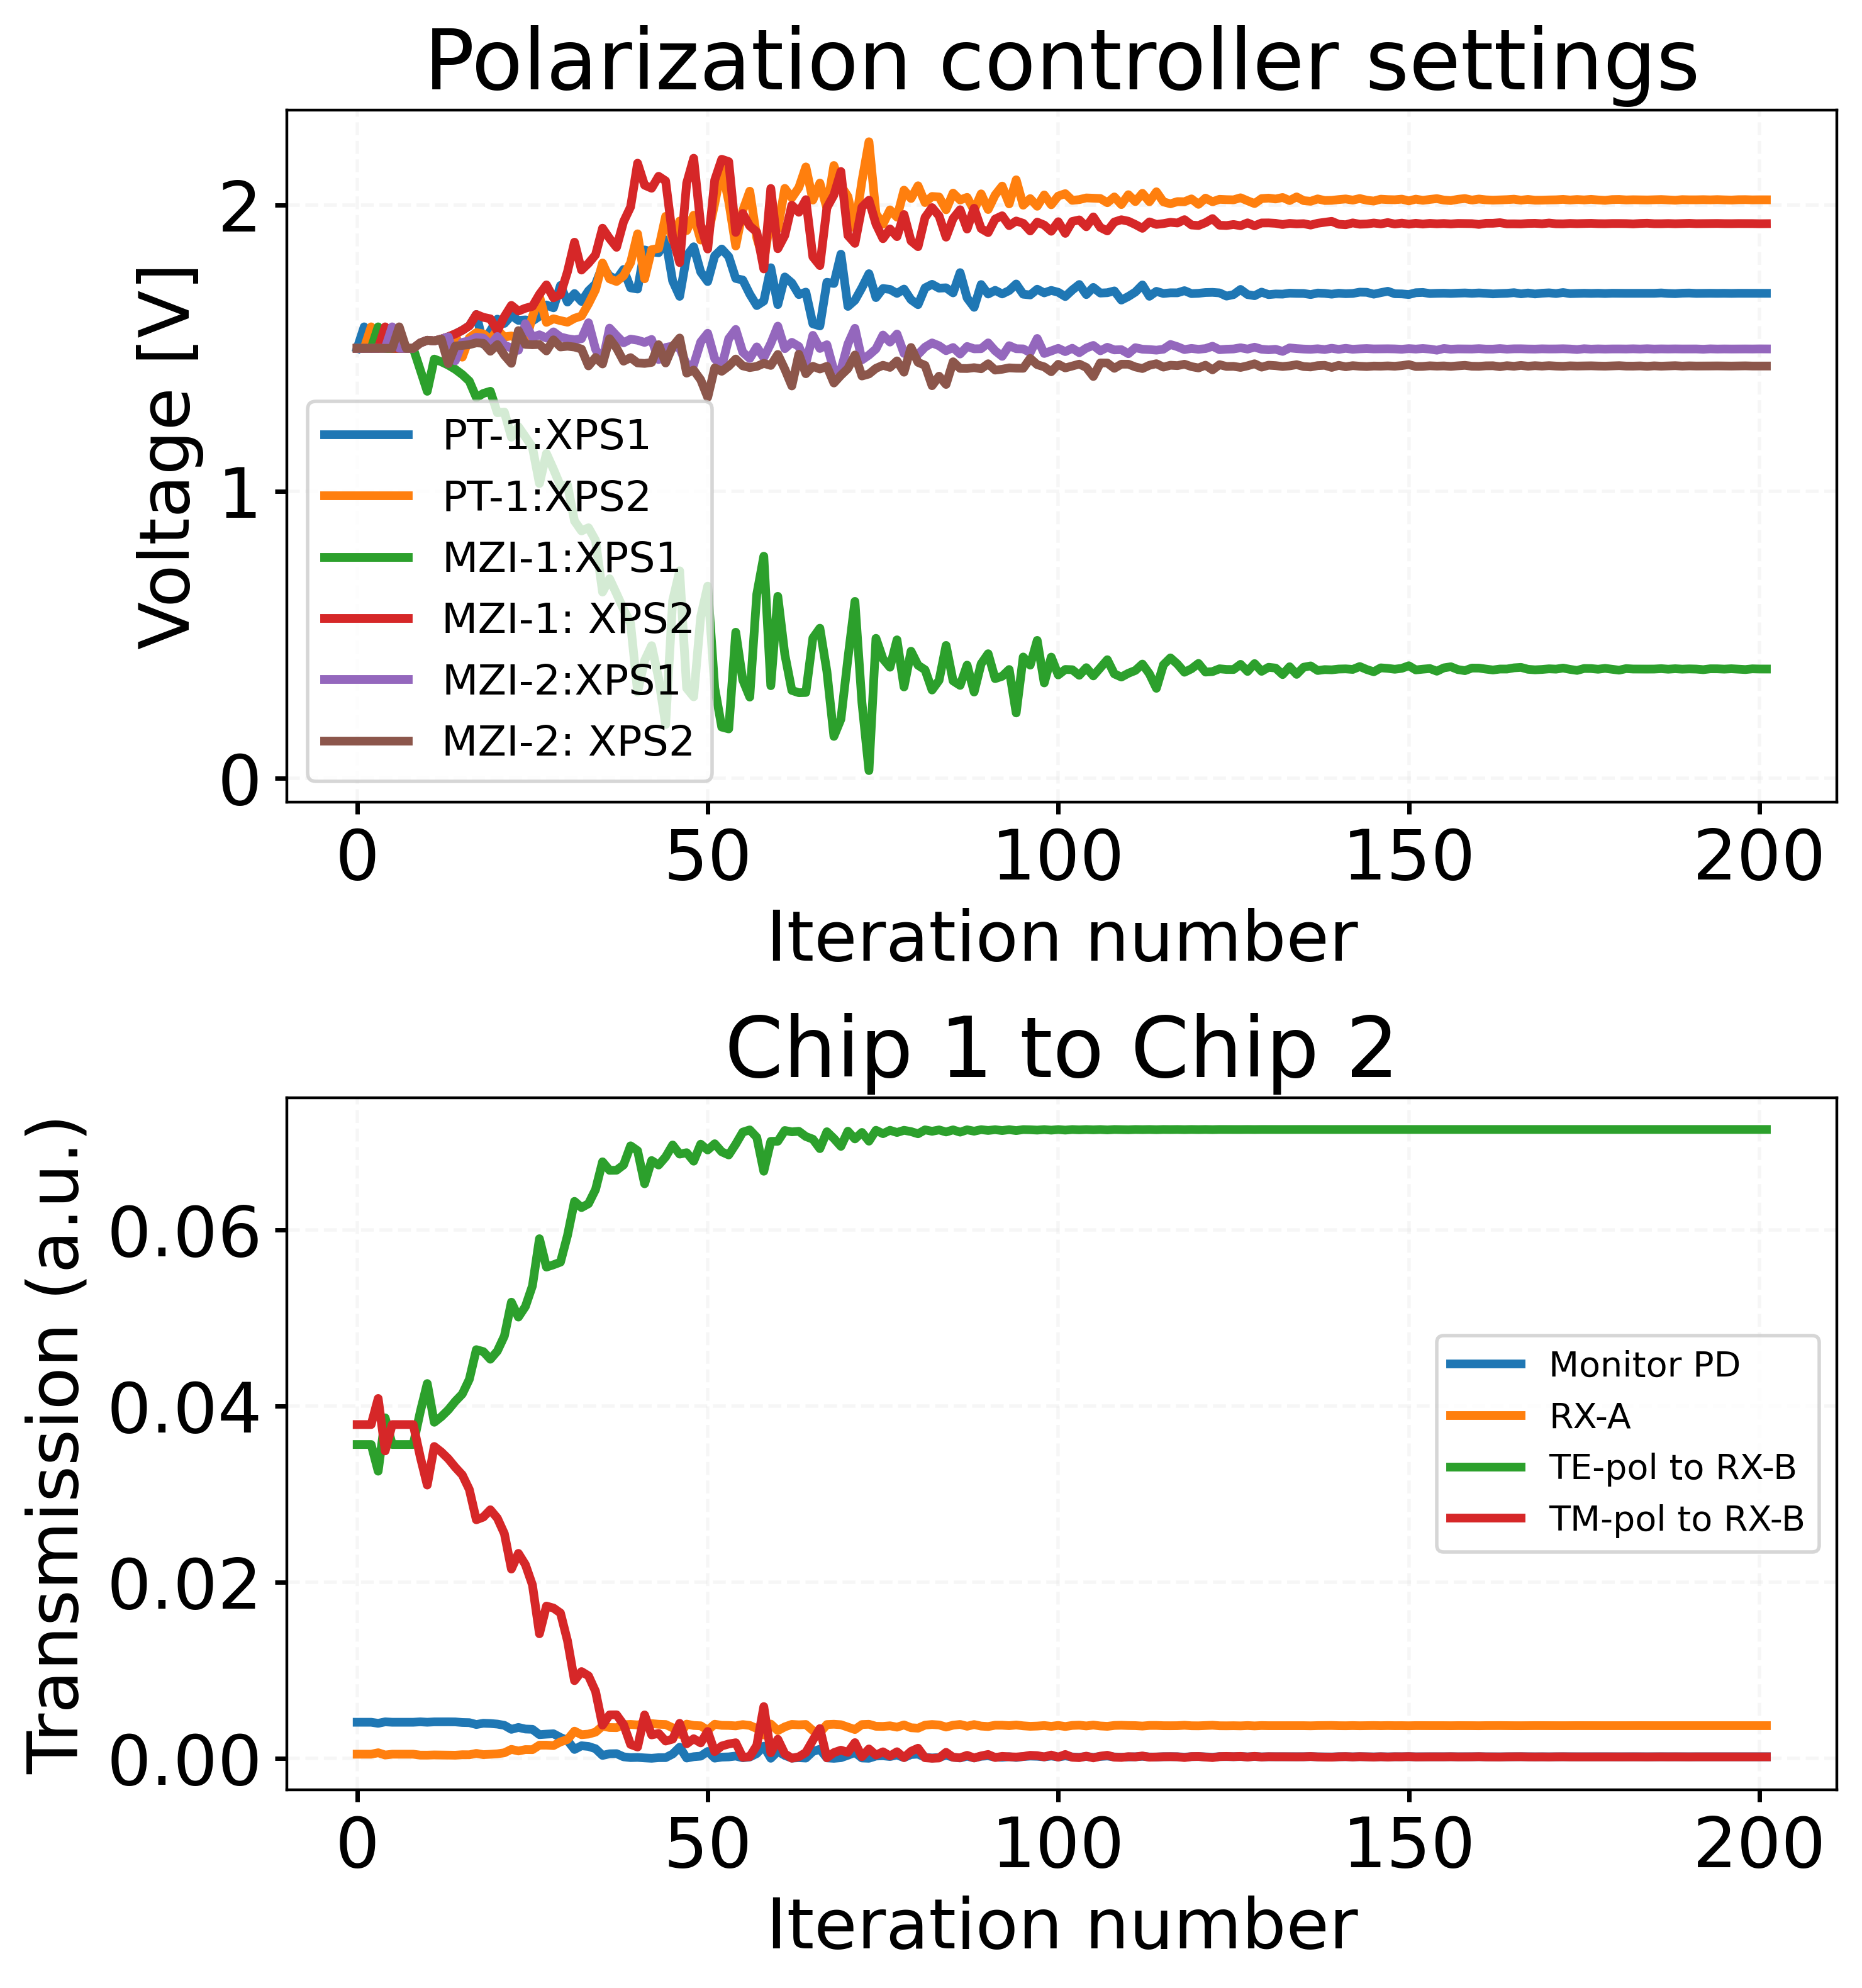

In [18]:
bounds = [(0, 3), (0, 3), (0, 3), (0, 3), (0,3), (0,3), (0,3), (0,3)]
input_state = np.array([0, 1, 0, 0])

opts = {
  "maxiter": 1000,
  'xatol': 1e-3,
  'fatol': 1e-3,
}

params = []

result = minimize(
  objective_function,
  ((1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5)),
  bounds=bounds,
  args=(input_state, params),
  method='Nelder-Mead',
  options=opts
  )

plot_optimization(params)

In [19]:
input_state = np.array([0, 1, 0, 0])
output_state = p_bidi.smatrix @ input_state
print("Output state: ", np.abs(output_state)**2)

input_state_reverse = np.array([0, 0, 1, 0])
output_state_reverse = p_bidi.smatrix @ input_state_reverse
print("Output state reverse: ", np.abs(output_state_reverse)**2)

Output state:  [0.00017662 0.0037089  0.07136808 0.00016733]
Output state reverse:  [1.85229951e-09 7.13680816e-02 1.49813277e-03 4.53643742e-05]
